In [2]:
from qsppack import nlfa
import numpy as np
from matplotlib import pyplot as plt

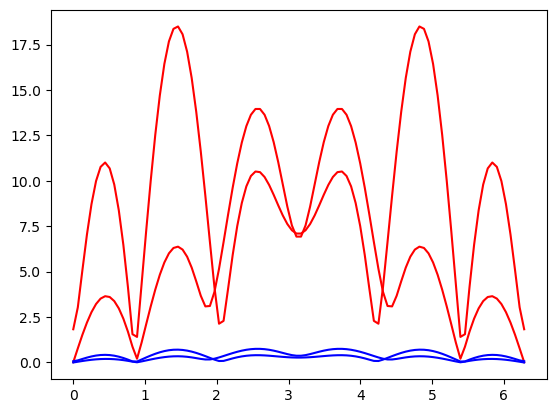

In [30]:
for _ in range(2):
    b = np.random.rand(8) * 10 -5
    bnorm = b / np.sum(np.abs(b))

    thetas = np.linspace(0, 2*np.pi, 100)
    bz = lambda theta: np.dot(b, np.exp(1j* (theta * np.arange(len(b)))))
    bz = np.vectorize(bz)
    bznorm = lambda theta: np.dot(bnorm, np.exp(1j* (theta * np.arange(len(bnorm)))))
    bznorm = np.vectorize(bznorm)

    plt.plot(thetas, np.abs(bz(thetas)), color="r")
    plt.plot(thetas, np.abs(bznorm(thetas)), color="b")
plt.show()

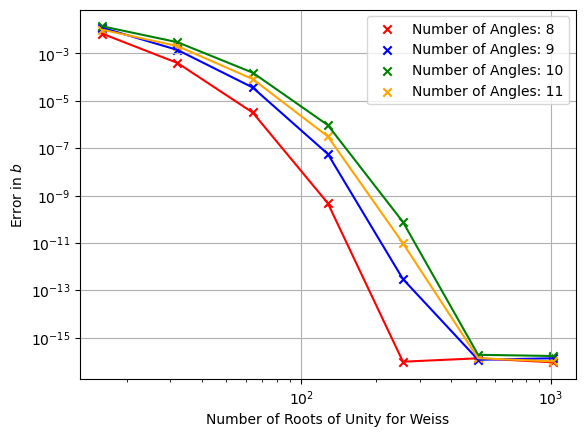

In [58]:
num_angles = np.arange(8,12)
colors = ["red", "blue", "green", "orange"]

for i, num_angle in enumerate(num_angles):
    b = np.random.rand(num_angle)
    b /= (np.sum(np.abs(b)) + 0.1)
    Nvals = 2**np.arange(4, 11)
    errs = np.zeros(len(Nvals))

    for j, N in enumerate(Nvals):
        a_star = nlfa.weiss(b, N)
        gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
        arr = nlfa.forward_nlft(gammas)
        errs[j] = np.linalg.norm(b-arr)

    plt.scatter(Nvals, errs, color=colors[i], marker="x", label=f"Number of Angles: {num_angle}")
    plt.plot(Nvals, errs, color=colors[i])

plt.xlabel("Number of Roots of Unity for Weiss")
plt.ylabel(r"Error in $b$")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best")
plt.grid()
plt.show()




In [60]:
num_angle = 8
N = 2**9
b = np.random.rand(num_angle)
b /= (np.sum(np.abs(b)) + 0.1)
Nvals = 2**np.arange(4, 11)
a_star = nlfa.weiss(b, N)
gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
arr = nlfa.forward_nlft(gammas)
print("error: ", np.linalg.norm(b-arr))

error:  1.4388796649533547e-16


In [62]:
num_angle = 8
N = 2**9
b = np.random.rand(num_angle)
b /= (np.sum(np.abs(b)) + 0.1)
Nvals = 2**np.arange(4, 11)
a_star = nlfa.weiss(b, N)
gammas, _, _ = nlfa.inverse_nonlinear_FFT(b, a_star)
arr = nlfa.forward_nlft(gammas)
print("error after flipping a_star and b: ", np.linalg.norm(a_star-arr))

error after flipping a_star and b:  1.7451007777668075e-16


In [63]:
num_angle = 50
N = 2**9
b = np.random.rand(num_angle)
b /= (np.sum(np.abs(b)) + 0.1)
Nvals = 2**np.arange(4, 11)
a_star = nlfa.weiss(b, N)
gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
arr = nlfa.forward_nlft(gammas)
print("error: ", np.linalg.norm(b-arr))

KeyboardInterrupt: 

In [231]:
import numpy as np
from scipy.signal import fftconvolve

def forward_nonlinear_FFT(gammas: np.ndarray, m=0, debug=False) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the forward nonlinear FFT, producing the polynomials a^* and b
    from the rotation parameters gammas.

    Parameters
    ----------
    gammas : np.ndarray
        Array of complex rotation parameters gamma_k of length n.
    m : int, optional
        starting index of gammas to use in the recursion.

    Returns
    -------
    tuple of np.ndarray
        A tuple (a_star, b) of length n+1 and n respectively, where a_star
        is the conjugate polynomial coefficients of a^*(z), and b is b(z).
    """
    n = len(gammas)

    # base case
    if n <= 2:
        prefactor = 1 / np.sqrt(1 + np.abs(gammas[0])**2)
        if n == 2:
            prefactor /= np.sqrt(1 + np.abs(gammas[1])**2)
        if debug:
            prefactor = 1
        b = prefactor * np.append(np.zeros(m), gammas)
        a_star = prefactor * np.array([1, -np.conj(gammas[0])*gammas[1]]) if n == 2 else np.array([prefactor])
        return a_star, b
    
    # recursive step
    m_new = int(np.ceil(n/2))
    if debug:
        print("m={}, n={}".format(m, n))
    a_star_left, b_left = forward_nonlinear_FFT(gammas[:m_new], debug=debug)
    a_star_right, b_right = forward_nonlinear_FFT(gammas[m_new:], m_new, debug=debug)
    
    # compute the convolution of the left and right parts
    if debug:
        print("a_star_left: ", a_star_left)
        print("b_left: ", b_left)
        print("a_star_right: ", a_star_right)
        print("b_right: ", b_right)
        print("b1: ", fftconvolve(np.conj(a_star_left[::-1]), b_right))
        print("b2: ", fftconvolve(a_star_right, b_left))
    b1 = fftconvolve(np.conj(a_star_left[::-1]), b_right)
    b1 = b1[len(a_star_left)-1:]
    b2 = fftconvolve(a_star_right, b_left)
    b2 = np.append(b2, np.zeros(len(b1)-len(b2)))
    a_star1 = -fftconvolve(np.conj(b_left[::-1]), b_right)
    a_star1 = a_star1[len(b_left)-1:]
    a_star2 = fftconvolve(a_star_left, a_star_right)
    a_star2 = np.append(a_star2, np.zeros(len(a_star1)-len(a_star2)))
    b = b1 + b2
    a_star = a_star1 + a_star2

    return a_star, np.append(np.zeros(m), b)


In [235]:
print(nlfa.forward_nlft(np.array([2,1,3,4,6,2,5,3,1])))
print(forward_nonlinear_FFT(np.array([2,1,3,4,6,2,5,3,1]), 0, debug=False)[1])

[ 1.56393248e-04 -1.22768700e-02  2.31852990e-01 -6.32688884e-01
 -2.47492315e-01 -2.56250337e-01  1.01421021e-01 -5.86474680e-03
  7.81966239e-05]
[ 1.56393248e-04 -1.22768700e-02  2.31852990e-01 -6.32688884e-01
 -2.47492315e-01 -2.56250337e-01  1.01421021e-01 -5.86474680e-03
  7.81966239e-05]


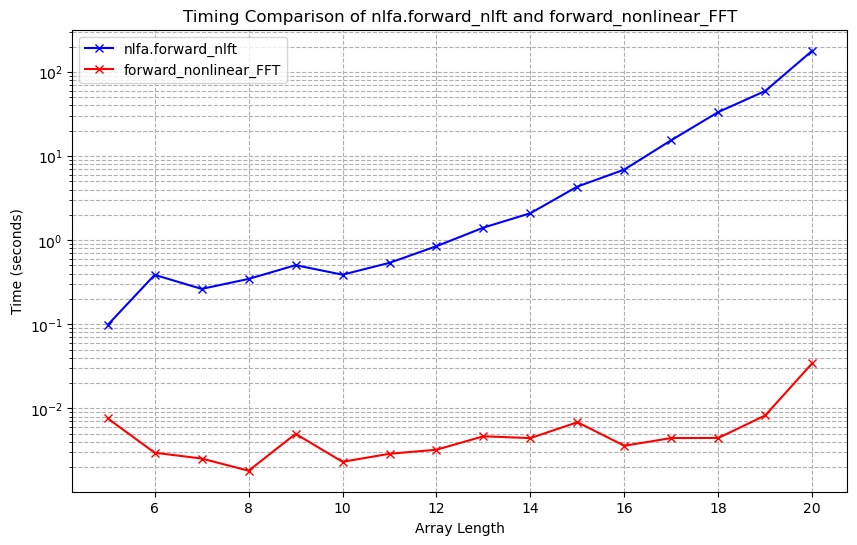

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define the functions to time
def time_function(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    return time.time() - start_time

# Array lengths to test
array_lengths = np.arange(5, 21)

# Store timing results
times_forward_nlft = []
times_forward_nonlinear_FFT = []

# Time each function with arrays of different lengths
for length in array_lengths:
    random_array = np.random.rand(length)
    
    # Time nlfa.forward_nlft
    time_nlft = time_function(nlfa.forward_nlft, random_array)
    times_forward_nlft.append(time_nlft)
    
    # Time forward_nonlinear_FFT
    time_fft = time_function(forward_nonlinear_FFT, random_array, 0, debug=False)
    times_forward_nonlinear_FFT.append(time_fft)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(array_lengths, times_forward_nlft, 'x-', label='nlfa.forward_nlft', color='blue')
plt.plot(array_lengths, times_forward_nonlinear_FFT, 'x-', label='forward_nonlinear_FFT', color='red')
plt.xlabel('Array Length')
plt.ylabel('Time (seconds)')
plt.yscale("log")
plt.title('Timing Comparison of nlfa.forward_nlft and forward_nonlinear_FFT')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig("timing_comparison.svg")


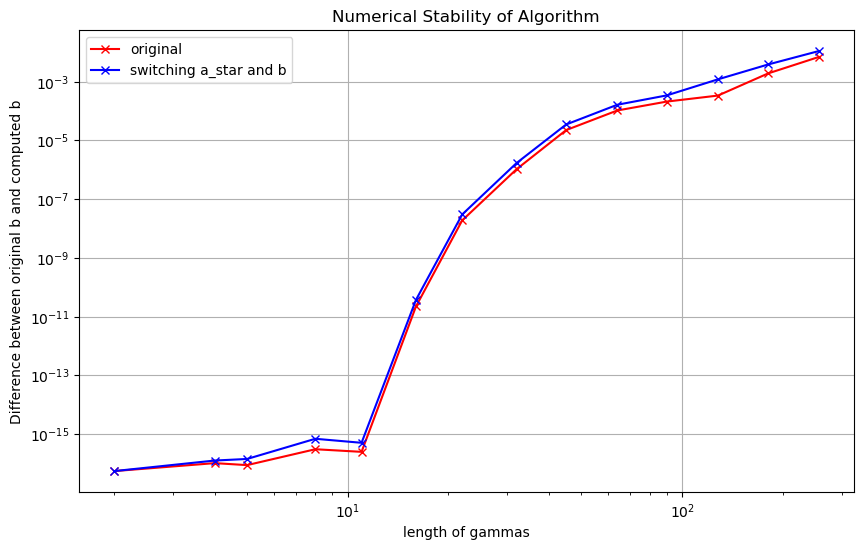

In [256]:
import matplotlib.pyplot as plt

# Define the range for num_angle
num_angle_values = (2**(np.arange(3, 17)/2)).astype(int)

# Store the norms for each num_angle
norms = []
norms_switch = []

# Loop over each num_angle value
for num_angle in num_angle_values:
    N = 2**9
    b = np.random.rand(num_angle)
    b /= (np.sum(np.abs(b)) + 0.1)
    a_star = nlfa.weiss(b, N)
    gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
    arr = forward_nonlinear_FFT(gammas)[1]
    norm_value = np.linalg.norm(b - arr)
    norms.append(norm_value)

    gammas, _, _ = nlfa.inverse_nonlinear_FFT(b, a_star)
    arr = forward_nonlinear_FFT(gammas)[1]
    norms_switch.append(np.linalg.norm(a_star - arr))

# Plot the results
plt.figure(figsize=(10, 6))
plt.loglog(num_angle_values, norms, 'x-', color='red', label="original")
plt.loglog(num_angle_values, norms_switch, 'x-', color='blue', label="switching a_star and b")
plt.xlabel('length of gammas')
plt.ylabel('Difference between original b and computed b')
plt.title('Numerical Stability of Algorithm')
plt.legend()
plt.grid(True)
plt.savefig("num_stab_nlft.svg")

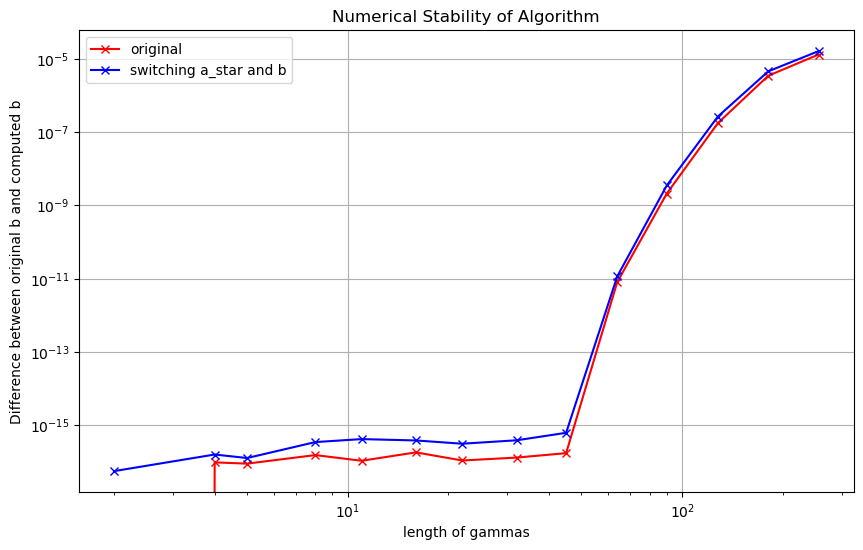

In [258]:
import matplotlib.pyplot as plt

# Define the range for num_angle
num_angle_values = (2**(np.arange(3, 17)/2)).astype(int)

# Store the norms for each num_angle
norms = []
norms_switch = []

# Loop over each num_angle value
for num_angle in num_angle_values:
    N = 2**12
    b = np.random.rand(num_angle)
    b /= (np.sum(np.abs(b)) + 0.1)
    a_star = nlfa.weiss(b, N)
    gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
    arr = forward_nonlinear_FFT(gammas)[1]
    norm_value = np.linalg.norm(b - arr)
    norms.append(norm_value)

    gammas, _, _ = nlfa.inverse_nonlinear_FFT(b, a_star)
    arr = forward_nonlinear_FFT(gammas)[1]
    norms_switch.append(np.linalg.norm(a_star - arr))

# Plot the results
plt.figure(figsize=(10, 6))
plt.loglog(num_angle_values, norms, 'x-', color='red', label="original")
plt.loglog(num_angle_values, norms_switch, 'x-', color='blue', label="switching a_star and b")
plt.xlabel('length of gammas')
plt.ylabel('Difference between original b and computed b')
plt.title('Numerical Stability of Algorithm')
plt.legend()
plt.grid(True)
plt.savefig("num_stab_nlft2.svg")

In [259]:
1e-14

1e-14

Checking k = 5 for num_angle = 2
Checking k = 5 for num_angle = 4
Checking k = 5.5 for num_angle = 4
Checking k = 6.0 for num_angle = 4
Checking k = 6.5 for num_angle = 4
Checking k = 7.0 for num_angle = 4
Checking k = 7.0 for num_angle = 5
Checking k = 7.5 for num_angle = 5
Checking k = 7.5 for num_angle = 8
Checking k = 8.0 for num_angle = 8
Checking k = 8.0 for num_angle = 11
Checking k = 8.5 for num_angle = 11
Checking k = 9.0 for num_angle = 11
Checking k = 9.0 for num_angle = 16
Checking k = 9.5 for num_angle = 16
Checking k = 10.0 for num_angle = 16
Checking k = 10.0 for num_angle = 22
Checking k = 10.5 for num_angle = 22
Checking k = 10.5 for num_angle = 32
Checking k = 11.0 for num_angle = 32
Checking k = 11.0 for num_angle = 45
Checking k = 11.5 for num_angle = 45
Checking k = 12.0 for num_angle = 45
Checking k = 12.0 for num_angle = 64
Checking k = 12.5 for num_angle = 64
Checking k = 12.5 for num_angle = 90
Checking k = 13.0 for num_angle = 90
Checking k = 13.5 for num_angl

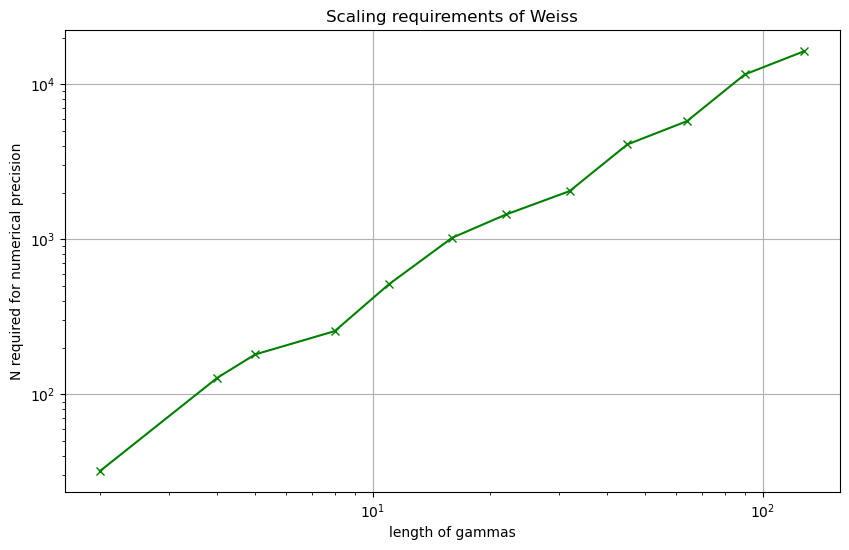

In [266]:
# Define the range for num_angle
num_angle_values = (2**(np.arange(3, 15)/2)).astype(int)
Nvals = []
k = 5

# Loop over each num_angle value
for num_angle in num_angle_values:
    norm_value = 1
    while norm_value > 1e-15:
        N = int(2**k)
        print("Checking k = {} for num_angle = {}".format(k, num_angle))
        b = np.random.rand(num_angle)
        b /= (np.sum(np.abs(b)) + 0.1)
        a_star = nlfa.weiss(b, N)
        gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
        arr = forward_nonlinear_FFT(gammas)[1]
        norm_value = np.linalg.norm(b - arr)
        if norm_value > 1e-15:
            k += 0.5
    Nvals.append(N)

# Plot the results
plt.figure(figsize=(10, 6))
plt.loglog(num_angle_values, Nvals, 'x-', color='green')
plt.xlabel('length of gammas')
plt.ylabel('N required for numerical precision')
plt.title('Scaling requirements of Weiss')
plt.grid(True)
plt.savefig("weiss_req.svg")

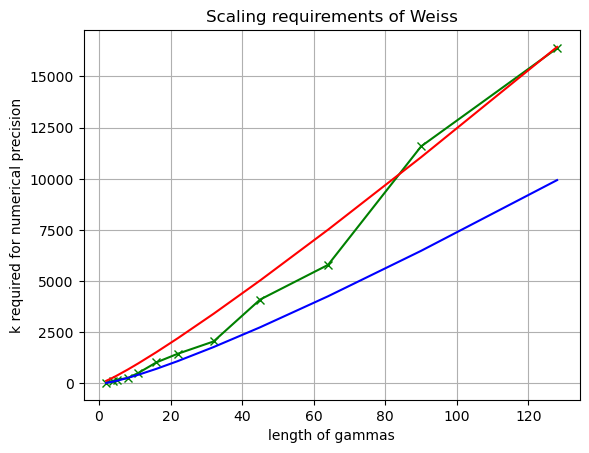

In [289]:
num_angles = np.array([2, 4, 5, 8, 11, 16, 22, 32, 45, 64, 90, 128])
ks = np.array([5, 7, 7.5, 8, 9, 10, 10.5, 11, 12, 12.5, 13.5, 14])

weiss_bound = lambda eta: 8 * num_angles / eta * np.log(576 * num_angles**2 / (eta**4 * 1e-12))

plt.plot(num_angles, 2**ks, 'x-', color='green')
plt.plot(num_angles, 8*num_angles*np.log(576*num_angles**2), '-', color='red')
plt.plot(num_angles, 8*num_angles*np.log(num_angles**2), '-', color='blue')
plt.xlabel('length of gammas')
plt.ylabel('k required for numerical precision')
plt.title('Scaling requirements of Weiss')
plt.grid(True)
plt.savefig("weiss_req2.svg")
